**Description:**
This Jupyter notebook is developed to show case the use of JSON header files for faster data access to NWM files. Here's a brief overview of the imported modules:

- `joblib`: Used for parallel processing and efficient caching.
- `numpy`: A fundamental library for numerical operations.
- `xarray`: A library for working with labeled multi-dimensional arrays, often used in scientific data analysis.
- `fsspec`: Provides a common interface for working with various filesystem-like protocols.
- `ujson`: A fast JSON encoder and decoder for handling JSON data.
- `matplotlib.pyplot`: Used for creating data visualizations.
- `psutil`: Provides information on system resource utilization.
- `concurrent.futures`: A module for asynchronously executing functions using threads or processes.
- `multiprocessing`: A library for parallel and concurrent computing.
- `urlgennwm`: An external library/module for generating URLs specific to the NWM (National Water Model).



In [5]:
import joblib
import numpy as np
import xarray as xr
import fsspec
import ujson
import matplotlib.pyplot as plt
import psutil
import concurrent.futures
import multiprocessing
import urlgennwm 


This code snippet retrieves and calculates system information, including the number of CPU cores and available memory in gigabytes (GB). It also computes a memory limit per worker process based on available resources. These metrics are essential for optimizing and parallelizing computational tasks.


In [6]:
# Get the number of available CPU cores
num_cores = psutil.cpu_count(logical=False)  # Use logical=True for hyperthreading

# Calculate the available memory in GB
available_memory_gb = psutil.virtual_memory().available / (1024 ** 3)  # Bytes to GB

# Calculate a memory limit per worker based on available memory
# Adjust this factor based on your memory usage requirements
memory_per_worker_gb = available_memory_gb / num_cores

This code defines a set of functions for working with remote datasets in JSON format. It includes functions to load remote JSON content, open datasets from JSON, select streamflow data, and select time values. The `process_file` function combines these operations to process a single file for a given feature ID, making it useful for retrieving and working with specific data from remote sources.

In [7]:
# Define a function to load remote JSON content
def load_remote_json(file_url):
    of = fsspec.open(file_url)
    with of as f:
        return ujson.load(f)

# Define a function to load a remote dataset from JSON content
def load_remote_ds(json_obj):
    backend_args = {
        "consolidated": False,
        "storage_options": {
            "fo": json_obj,
        },
    }
    return xr.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

# Define a function to select streamflow data from a dataset
def select_flow(ds, feature_id):
    cords = ds.streamflow.sel(feature_id=feature_id)
    return cords.values

# Define a function to select time
def select_time(ds):
    dstime = ds.time
    return dstime.values

# Define a function to process a single file for a given feature ID
def process_file(file_url, feature_id):
    json_obj = load_remote_json(file_url)
    ds = load_remote_ds(json_obj)
    streamflow_value = select_flow(ds, feature_id)
    time_value = select_time(ds)
    return streamflow_value, time_value



This code defines a list of feature IDs, which are typically used as identifiers for specific geographic or data features. In this case, the list includes feature IDs `8153461`, `8153027`, and `18210860`, representing specific features of interest. These feature IDs are used in subsequent data retrieval. Feature IDs could for different locations could be found at https://water.noaa.gov/map#forecast-chart


In [8]:
# Define a list of feature IDs
feature_ids = [8153461, 8153027, 18210860]

**Description:**
This code block sets input variables to specify the parameters required for generating National Water Model (NWM) JSON header URLs. These URLs are utilized to access data related to the NWM for various configurations. Here's an overview of the input variables:

- `start_date`: A string representing the starting date in the format "YYYYMMDDHHMM."
- `end_date`: A string representing the ending date in the same format.
- `fcst_cycle`: A list of integers specifying forecast cycle numbers, e.g., `[0, 1, 2, 3, 4]`. These cycles represent specific points in time for which URLs will be generated.
- `lead_time`: A list of integers indicating lead times in hours for forecasts. It determines the time ahead of the forecast start, e.g., `[1, 2, 3, 4]`.
- `varinput`: An integer or string representing the variable of interest within the NWM data. Available options include:
  - `1` or `"channel_rt"` for channel routing data.
  - `2` or `"land"` for land data.
  - `3` or `"reservoir"` for reservoir data.
  - `4` or `"terrain_rt"` for terrain routing data.
  - `5` or `"forcing"` for forcing data.
- `geoinput`: An integer or string specifying the geographic region of interest. Options include:
  - `1` or `"conus"` for the continental United States.
  - `2` or `"hawaii"` for Hawaii.
  - `3` or `"puertorico"` for Puerto Rico.
- `runinput`: An integer or string representing the NWM run configuration. Available options include:
  - `1` or `"short_range"` for short-range forecasts.
  - `2` or `"medium_range"` for medium-range forecasts.
  - `3` or `"medium_range_no_da"` for medium-range forecasts without data assimilation.
  - `4` or `"long_range"` for long-range forecasts.
  - `5` or `"analysis_assim"` for analysis-assimilation runs.
  - `6` or `"analysis_assim_extend"` for extended analysis-assimilation runs.
  - `7` or `"analysis_assim_extend_no_da"` for extended analysis-assimilation runs without data assimilation.
  - `8` or `"analysis_assim_long"` for long analysis-assimilation runs.
  - `9` or `"analysis_assim_long_no_da"` for long analysis-assimilation runs without data assimilation.
  - `10` or `"analysis_assim_no_da"` for analysis-assimilation runs without data assimilation.
  - `11` or `"short_range_no_da"` for short-range forecasts without data assimilation.

After defining these parameters, the code calls the `urlgennwm.generate_urls` function, passing in these variables as arguments. This function generates a list of URLs tailored to the specified parameters, allowing the retrieval of specific NWM data for further analysis or modeling.


In [22]:
# Setting input variables to generate NWM JSON header urls
start_date = "202201120000"
end_date   = "202201130000"
fcst_cycle = [0]
lead_time = lead_time = [1, 2, 240]
varinput = 1
geoinput = 1
runinput = 1
urlgennwm.generate_urls(start_date, end_date, fcst_cycle, lead_time, varinput, geoinput, runinput)

This code snippet initializes an empty list called `files` to store URLs. It then specifies the name of a file, "filenamelist.txt," which contains a list of URLs. The code opens this file in read mode, reads the URLs line by line, removes leading and trailing whitespace from each line, and appends each URL to the `files` list. Finally, it initializes an empty dictionary called `extracted_values_dict`,  intended to store extracted values associated with specific feature IDs.

In [23]:
# Initialize an empty list to store the URLs
files = []

# Define the name of the file containing the URLs
filename = "filenamelist.txt"

# Open the file in read mode and read the URLs line by line
with open(filename, "r") as file:
    for line in file:
        # Remove leading and trailing whitespace and append the URL to the list
        url = line.strip()
        files.append(url)
# Create a dictionary to store the extracted values for each feature ID
extracted_values_dict = {}

This code snippet utilizes the `joblib` library to create a parallel processing pool using threading for dynamic settings. It processes a list of `files` using the `process_file` function in parallel, passing each `file_url` and the `feature_ids` list as arguments. The results are stored in `result_values` and sorted based on the first element of each result tuple. The extracted streamflow values are then stored in the `Streamflow` list, and the associated timestamps are stored in the `Timestamp` list, which can be further used for analysis or visualization.

In [24]:
# Create a Parallel processing pool using joblib with dynamic settings
with joblib.parallel_backend("threading", n_jobs=num_cores):  # Use threads for parallel processing
    result_values = joblib.Parallel()(joblib.delayed(process_file)(file_url, feature_ids) for file_url in files)
result_values = sorted(result_values, key=lambda x: x[1][0])
Streamflow = [item[0] for item in result_values]
Timestamp = [item[1] for item in result_values]


This code snippet creates separate plots for each feature ID in the `feature_ids` list. For each feature ID, it plots the time series of the extracted streamflow values using Matplotlib. The streamflow values are stored in the `Streamflow` list, and each plot is labeled with the corresponding feature ID. The x-axis represents time in hours, and the y-axis represents streamflow values. Finally, the code displays all the separate plots.


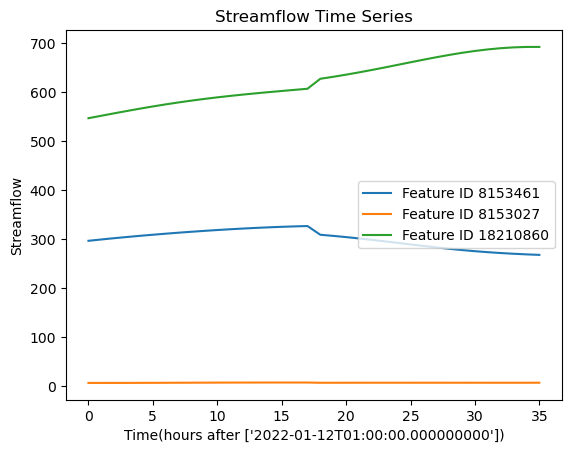

In [25]:
# Create separate plots for each feature ID
    # Plot the time series of the extracted streamflow values for the current feature ID using Matplotlib
plt.figure()
plt.plot(Streamflow, label=[f"Feature ID {feature_id}" for feature_id in feature_ids])
plt.xlabel(f"Time(hours after {min(Timestamp)})")
#plt.xlabel("Time(hours)")
plt.ylabel("Streamflow")
plt.title(f"Streamflow Time Series")
plt.legend()
# Show all the separate plots
plt.show()